Adapted from [MultivariateStats.jl](https://juliastats.org/MultivariateStats.jl/stable/pca/).

In [1]:
using BenchmarkTools, RDatasets, Plots

In [2]:
# load iris dataset
iris = dataset("datasets", "iris")

# split half to training set
Xtr = Matrix(iris[1:2:end,1:4])'
Xtr_labels = Vector(iris[1:2:end,5])

# split other half to testing set
Xte = Matrix(iris[2:2:end,1:4])'
Xte_labels = Vector(iris[2:2:end,5]);

# MultivariateStats.jl

## PCA

In [3]:
using MultivariateStats

In [4]:
@benchmark fit(PCA, Xtr; maxoutdim=3)

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.712 μs …  2.360 ms  ┊ GC (min … max): 0.00% … 98.28%
 Time  (median):     8.028 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.626 μs ± 34.198 μs  ┊ GC (mean ± σ):  7.56% ±  2.36%

  ██▄▃▂▂▁                                                    ▁
  ██████████▇▇▇▆▆▆▆▇▇▆▇▇▇▇██▇█▇▇▇▇▆▇▆▆▅▄▅▅▅▅▄▃▄▄▄▅▄▄▅▂▄▄▄▅▄▃ █
  7.71 μs      Histogram: log(frequency) by time     23.5 μs <

 Memory estimate: 6.50 KiB, allocs estimate: 37.

In [5]:
@benchmark predict(M, Xte) setup=(M=fit(PCA, Xtr; maxoutdim=3))

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.147 μs … 681.684 μs  ┊ GC (min … max):  0.00% … 98.99%
 Time  (median):     1.299 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.816 μs ±  13.243 μs  ┊ GC (mean ± σ):  19.72% ±  2.94%

  ▇█▇█▆▃▁▁           ▁▁                                       ▂
  ██████████▇▇▇▇▆▆▅▆████▇▇▇▆▅▄▅▄▃▅▅▆▄▅▅▆▄▄▄▄▄▆▅▄▆▇▆▆▅▆▆▇▆▆▆▆▅ █
  1.15 μs      Histogram: log(frequency) by time      4.63 μs <

 Memory estimate: 4.56 KiB, allocs estimate: 5.

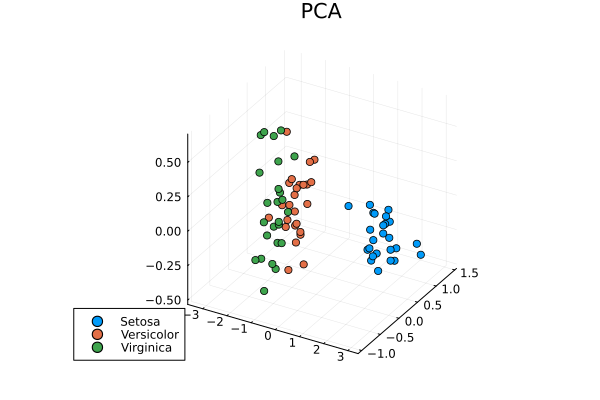

In [6]:
function plot_compression(Yte, title)
    setosa_Y = Yte[:, Xte_labels .== "setosa"]
    versicolor_Y = Yte[:, Xte_labels .== "versicolor"]
    virginica_Y = Yte[:, Xte_labels .== "virginica"]
    p = scatter(setosa_Y[1, :], setosa_Y[2, :], setosa_Y[3, :], marker=:circle, linewidth=0, label="Setosa")
    scatter!(versicolor_Y[1, :], versicolor_Y[2, :], versicolor_Y[3, :], marker=:circle, linewidth=0, label="Versicolor")
    scatter!(virginica_Y[1, :], virginica_Y[2, :], virginica_Y[3, :], marker=:circle, linewidth=0, label="Virginica")
    plot!(p, title=title)
    return p
end

M = fit(PCA, Xtr; maxoutdim=3)
pca_pred = predict(M, Xte)
p1 = plot_compression(pca_pred, "PCA")

# ExpFamilyPCA

## PoissonEPCA

In [7]:
using Revise
using ExpFamilyPCA

Observe that even with printing, `PoissonEPCA` is nearly four times faster than `PCA` in `MultivariateStats.jl`.

In [8]:
@benchmark PoissonEPCA()

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):   6.105 ns …  3.265 μs  ┊ GC (min … max):  0.00% … 98.53%
 Time  (median):      7.237 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   11.546 ns ± 81.521 ns  ┊ GC (mean ± σ):  21.62% ±  3.10%

  ▇█▇▅▄▃▂▁▁▁ ▁▁                                               ▂
  ██████████████▇▇▇▆▅▆▆▆▆▆▆▆▆▆▆▅▅▄▅▄▅▅▄▅▃▂▅▅▅▆▅▇▇▆▅▆▆▆▆▆▆▇▆▇▆ █
  6.1 ns       Histogram: log(frequency) by time      40.2 ns <

 Memory estimate: 48 bytes, allocs estimate: 1.

In [9]:
Xtr_transpose = Xtr'
@benchmark fit!(poisson, Xtr_transpose; maxoutdim=3, verbose=false, maxiter=5) setup=(poisson=PoissonEPCA())

BenchmarkTools.Trial: 14 samples with 1 evaluation.
 Range (min … max):  365.007 ms … 401.339 ms  ┊ GC (min … max): 14.27% … 19.45%
 Time  (median):     376.666 ms               ┊ GC (median):    17.03%
 Time  (mean ± σ):   378.678 ms ±  11.544 ms  ┊ GC (mean ± σ):  16.82% ±  1.63%

  █▁     ▁     ▁▁    ▁▁  ▁    ▁        ▁  ▁             ▁     ▁  
  ██▁▁▁▁▁█▁▁▁▁▁██▁▁▁▁██▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█ ▁
  365 ms           Histogram: frequency by time          401 ms <

 Memory estimate: 255.30 MiB, allocs estimate: 169278.

In [10]:
poisson = PoissonEPCA()
fit!(poisson, Xtr_transpose; maxoutdim=3, verbose=false, maxiter=5)
Xte_transpose = Xte'
@benchmark compress(poisson, Xte_transpose; maxiter=5)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  235.021 ms … 324.784 ms  ┊ GC (min … max): 3.55% … 3.74%
 Time  (median):     248.162 ms               ┊ GC (median):    5.09%
 Time  (mean ± σ):   258.263 ms ±  24.730 ms  ┊ GC (mean ± σ):  4.86% ± 1.09%

  ▃  █   ▃▃▃   ▃                                                 
  █▁▁█▇▁▁███▁▁▁█▁▁▁▁▁▁▇▁▁▁▁▁▇▇▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▇ ▁
  235 ms           Histogram: frequency by time          325 ms <

 Memory estimate: 83.35 MiB, allocs estimate: 61913.

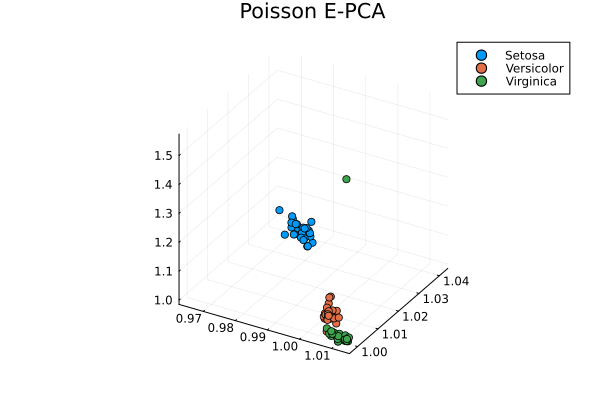

In [11]:
poisson_pred = compress(poisson, Xte_transpose; maxiter=5)'
p2 = plot_compression(poisson_pred, "Poisson E-PCA")

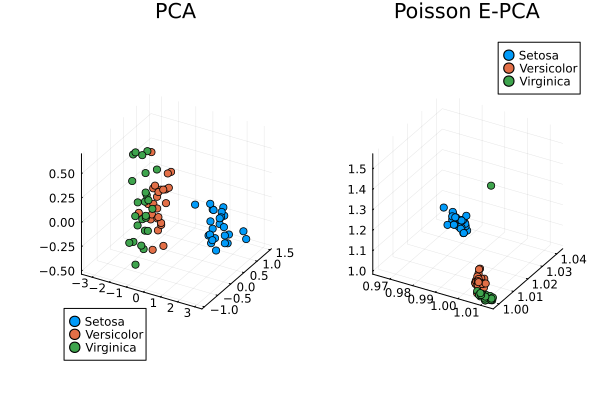

In [12]:
plot(p1, p2, layout=(1, 2))

Now, let's see how PCA and Poisson E-PCA fair on reconstruction.

In [13]:
@benchmark reconstruct(M, pca_pred)

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.014 μs …  1.294 ms  ┊ GC (min … max):  0.00% … 99.41%
 Time  (median):     1.338 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.666 μs ± 34.023 μs  ┊ GC (mean ± σ):  40.05% ±  3.14%

  ▆▇▄█▇▂▁▁▁▁           ▁▁▁▁                                  ▂
  ████████████▇▇▇▇▇▅▆▇▇█████▇▇▆▆█▇██▇▆▇▇▇▇▇▇▆▆▆▅▅▅▄▄▆▄▅▅▃▄▄▄ █
  1.01 μs      Histogram: log(frequency) by time     5.99 μs <

 Memory estimate: 5.00 KiB, allocs estimate: 2.

In [14]:
Xr_PCA = reconstruct(M, pca_pred)

4×75 Matrix{Float64}:
 4.86449  4.61087   5.40782   5.00775   …  6.79346  6.58825  6.46774  5.94384
 3.04262  3.08695   3.89061   3.39069      3.20785  3.13416  3.03873  2.94737
 1.46099  1.48132   1.68656   1.48668      5.91124  5.39197  5.25542  5.02469
 0.10362  0.229519  0.421233  0.221041     2.28224  1.99665  1.91243  1.91901

In [15]:
poisson_pred_transpose = poisson_pred'
@benchmark decompress(poisson, poisson_pred_transpose)

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.849 μs …  1.302 ms  ┊ GC (min … max):  0.00% … 99.27%
 Time  (median):     2.192 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.415 μs ± 33.021 μs  ┊ GC (mean ± σ):  29.63% ±  3.14%

  ▅▇▅▇█▄▁              ▁▁▁▁                                  ▂
  ███████▇█▆▅▇▇▇▇███▇▇████████▆▇▇▇███▇███▇▇▇▆▇▇▆▆▃▅▅▅▅▆▅▆▄▁▄ █
  1.85 μs      Histogram: log(frequency) by time     6.91 μs <

 Memory estimate: 5.00 KiB, allocs estimate: 2.

In [16]:
Xr_poisson = decompress(poisson, poisson_pred')'

4×75 adjoint(::Matrix{Float64}) with eltype Float64:
 5.54346  5.52601   5.65065   5.55848   …  6.1317   6.09795  6.10442  6.09127
 3.28955  3.29516   3.23915   3.29412      2.93371  2.9392   2.94051  2.9478
 2.27886  2.24901   2.53285   2.28713      4.35927  4.2829   4.27912  4.22463
 0.49512  0.485688  0.584433  0.496757     1.39053  1.35845  1.35333  1.32683

In [17]:
pca_absolute_error = sum(abs.(Xr_PCA .- Xte))
poisson_absolute_error = sum(abs.(Xr_poisson .- Xte))

println("PCA Absolute Error: ", pca_absolute_error)
println("Poisson Absolute Error: ", poisson_absolute_error)

PCA Absolute Error: 18.37633501091988
Poisson Absolute Error: 150.03483471266802


Both, reconstruct the data nearly instantly.

## Implicit Poisson

One of the main features of ExpFamilyPCA.jl is the ability to induce a custom E-PCA objective from a user-provided convex function $G$. For example, to induce the Poisson E-PCA objective, we set $G = \exp(x)$. While this method is convenient for experimenting with different $G$ and link functinos, it is often slower than an explicit model that defines the Bregman divergence.

In [22]:
@benchmark EPCA(x->exp(x))

BenchmarkTools.Trial: 2131 samples with 1 evaluation.
 Range (min … max):  1.174 ms … 37.983 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.245 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.336 ms ±  1.229 ms  ┊ GC (mean ± σ):  0.52% ± 2.84%

  ▃█▇▅▆▄▁▃                       ▁                            
  ████████▆▇▇▆▇▆▇▄▇▅▄▇▅▇▇▇▇▇██▇█▇█▇▆▆▅▇▅▅▆▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▁▂ ▄
  1.17 ms        Histogram: frequency by time        4.32 ms <

 Memory estimate: 64.69 KiB, allocs estimate: 1184.

In [24]:
@benchmark fit!(implicit_poisson, Xtr_transpose, 1; maxoutdim=3, maxiter=5) setup=(implicit_poisson=EPCA(x->exp(x)))

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  446.397 ms … 820.857 ms  ┊ GC (min … max): 12.16% … 6.70%
 Time  (median):     470.101 ms               ┊ GC (median):    14.09%
 Time  (mean ± σ):   508.102 ms ± 112.419 ms  ┊ GC (mean ± σ):  12.55% ± 2.68%

  ▁██  █ ▁     ▁                                              ▁  
  ███▁▁█▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  446 ms           Histogram: frequency by time          821 ms <

 Memory estimate: 310.21 MiB, allocs estimate: 195189.

In [26]:
implicit_poisson = PoissonEPCA()
fit!(poisson, Xtr_transpose; maxoutdim=3, verbose=false, maxiter=5)
@benchmark compress(poisson, Xte_transpose; maxiter=5)

BenchmarkTools.Trial: 19 samples with 1 evaluation.
 Range (min … max):  246.899 ms … 357.894 ms  ┊ GC (min … max): 5.18% … 6.43%
 Time  (median):     253.648 ms               ┊ GC (median):    6.63%
 Time  (mean ± σ):   271.929 ms ±  36.248 ms  ┊ GC (mean ± σ):  6.11% ± 0.99%

    ██  ▁                                                        
  ▆▆██▆▁█▆▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▆▁▁▁▁▁▆ ▁
  247 ms           Histogram: frequency by time          358 ms <

 Memory estimate: 90.85 MiB, allocs estimate: 68241.

In [27]:
implicit_poisson_pred = compress(implicit_poisson, Xte_transpose; maxiter=5)'
p3 = plot_compression(implicit_poisson_pred, "Implicit Poisson E-PCA")

MethodError: MethodError: no method matching size(::Missing)

Closest candidates are:
  size(!Matched::Base.AsyncGenerator)
   @ Base asyncmap.jl:389
  size(!Matched::SciMLOperators.NullOperator)
   @ SciMLOperators ~/.julia/packages/SciMLOperators/Kto0y/src/basic.jl:114
  size(!Matched::PrettyTables.RowTable)
   @ PrettyTables ~/.julia/packages/PrettyTables/E8rPJ/src/tables.jl:114
  ...


In [21]:
implicit_Xr_poisson = decompress(Poisson, A')'

UndefVarError: UndefVarError: `Poisson` not defined